<a href="https://colab.research.google.com/github/ilkzeyden/call-center-customer-conversationsclustering-and-classification/blob/main/gensim_lda_taraf%C4%B1ndan_%C3%A7%C4%B1kar%C4%B1lan_5_konu_lstm_s%C4%B1n%C4%B1fland%C4%B1rma_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd # Veri yapıları ile çalışmak için pandas modülü.
from sklearn import metrics

In [ ]:
df = pd.read_excel('df_5_toplam.xlsx')
df.drop(columns=['Unnamed: 0'],inplace=True)
df


,Baskın Konu,Yazı
0,9,kaldım saat derecede evde sırf...
1,9,faruk klima gece ilk çalıştırdım yapıla...
2,11,çalışmalar ceylan televizyon yeni ...
3,11,çamaşır makine sorun servis talep edecek...
4,11,ezgi televizyon arıza ücret paneli gidiş...
...,...,...
8979,11,ibrahim klima kurulum buray...
8980,9,görüntülü anlamam telefon ısıtmıy...
8981,2,telefon garanti oraya kayıtımın almışlardı ...
8982,3,işler yorum durumum vardı media mar...


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
 # Makinenin yazıyı anlayabilmesi için Tokenizer ile veri setinde kullanılan en çok 50000 kelime ile bir sözlük oluşturulur.

tokenizer = Tokenizer(num_words=50000) # sözlük oluşturulur.
tokenizer.fit_on_texts(df['Yazı']) # yazılar tokene dönüştürülür.

In [ ]:
# Verimiz için bir cümle uzunluğu hesaplanır.
import numpy as np # Dizi işlemleri için numpy modülü.

# toplam token sayısı
num_tokens = [len(tokens) for tokens in df['Yazı']]
num_tokens = np.array(num_tokens)

# max token sayısı
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

2261

In [ ]:
# Sinir ağımız bizden girdileri eşit boyutta istiyor. Gerçek hayattaki problemlerde bu çok zordur. Bu yüzden verileri aynı boyuta getirmek için pad_sequences kullanılır.
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['Yazı']) # cümleleri sözlükteki kelimelerin karşılığına çevrilir.

X_pad = pad_sequences(X, maxlen=max_tokens) # pad_sequences ile aynı boyuta getirilir. uzunluk olarak da önceden hesapladığımız cümle boyutu max_tokens koydum.

In [ ]:
# verimiz dengesiz olduğu için RandomOverSampler ile verimizi yeniden örnekliyoruz.
from imblearn.over_sampling import RandomOverSampler

Y = pd.get_dummies(df['Baskın Konu']).values # çıktı verilerimiz anlayacağı hale getirdik.

rus = RandomOverSampler(random_state = 0, sampling_strategy = "minority") # RandomUnderSampler parametreleri belirlenerek değişkene atanır. sampling_strategy, örnekleme stratejisi, minority olarak belirlendi. Çünkü verilerimiz dengesiz olduğu için azınlıkları(minority) yeniden örnekleyerek veriyi dengelemeye çalışıyoruz.
x_rus, y_rus = rus.fit_resample(X_pad, Y) # veriler yeniden örneklendirilir.

In [ ]:
from sklearn.model_selection import train_test_split # verileri eğitim ve test diye bölünür.
x_train, x_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size = 0.25, random_state = 42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7721, 2261) (7721, 5)
(2574, 2261) (2574, 5)


In [ ]:
from tensorflow import keras # yapay sinir ağı kullanmak için keras yüklenir.
from math import exp
import matplotlib.pyplot as plt

model = keras.Sequential() # Bir sıralı(Sequential) model, tek girdi ve tek çıktı katmanın olduğu derin öğrenme modeli oluşturmaya yarar.
model.add(keras.layers.Embedding(50000, 100, input_length=max_tokens)) # yazıyı vektörlere çevirir. Tanımı: Pozitif tamsayı (indeksleri) sabit boyutta yoğun vektörlere dönüştürür.
model.add(keras.layers.LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(keras.layers.Dense(5, activation='softmax')) # çıktı katmanı. SoftMAX aktivasyon fonksiyonu, göreceli olasılıkları hesaplar. çoklu sınıf olduğu için softmax kullanılır. ağın son katmanı için aktivasyon olarak kullanılır, çünkü sonuç bir olasılık dağılımı olarak yorumlanabilir. softmanx kullanılmasının sebebi modelin multi-class ve bir doğru cevabın olmasındandır.

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # çok sınıflı sınıflandırma problemi olduğu için categorical_crossentropy kullanıldı.

epochs = 28 # Algoritmasının tüm eğitim veri kümesinde kaç kere çalışacağını belirtir.
batch_size = 512 # batch, bir veya daha fazla örnek üzerinde yineleme yapan ve tahminlerde bulunan için bir döngü sayısıdır. her örnekten sonra tahminler beklenen çıktılarla karşılaştırılır ve bir hata hesaplanır. hataya göre tahmini iyileştirmeye çalışır.

#callback = (keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001))# model çalıştırılır(validation loss'u gözle eğer 3 epochdur(devirdir) en az 0.0001 gelişmiyorsa eğitimi durdur.)

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=[x_test,y_test]) # model çalıştırılır

# modelimizin test verileri doğruluğu
accr = model.evaluate(x_test, y_test)
print(f"Test Loss: {accr[0]}, Test Accuracy: {accr[1]}")



Epoch 1/28
16/16 ━━━━━━━━━━━━━━━━━━━━ 1372s 86s/step - accuracy: 0.2502 - loss: 1.5981 - val_accuracy: 0.2832 - val_loss: 1.5550
Epoch 2/28
16/16 ━━━━━━━━━━━━━━━━━━━━ 569s 35s/step - accuracy: 0.3830 - loss: 1.4902 - val_accuracy: 0.4771 - val_loss: 1.3477
Epoch 3/28
 7/16 ━━━━━━━━━━━━━━━━━━━━ 5:24 36s/step - accuracy: 0.4496 - loss: 1.3344

In [ ]:
y_pred = model.predict(x_test, batch_size=512, verbose=0)

# karmaşıklık matrisi için y_pred ve y_test değerlerimizi argmax() ile satır bazlı bakılarak maksimum değerinin sırasının listesine dönüştürülür.
rounded_y_pred = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(y_test, axis=1)

# sınıflandırma raporu
from sklearn import metrics
cr = metrics.classification_report(rounded_labels, rounded_y_pred, zero_division=0)
print(cr)

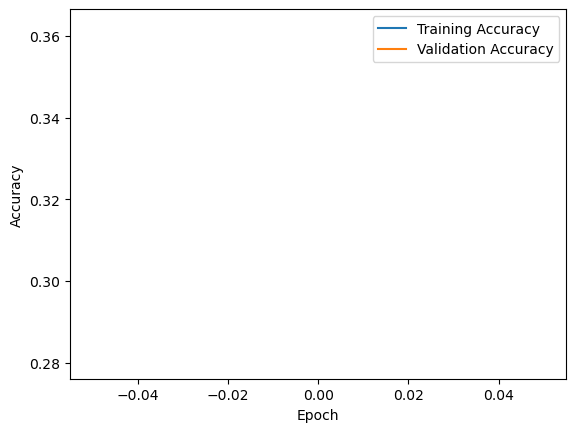

In [ ]:
# Eğitim süreci ve doğrulama kayıplarını ve doğruluklarını görselleştirme
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kayıplarını ve doğruluklarını DataFrame'e dönüştürme
history_df = pd.DataFrame(history.history)

# Modelin test sonuçlarını DataFrame'e ekleme
test_results = pd.DataFrame({'test_loss': [accr[0]], 'test_accuracy': [accr[1]]})

# Tüm sonuçları birleştirme
results_df = pd.concat([history_df, test_results], axis=1)

# Sonuçları Excel dosyasına yazma
results_df.to_excel('model_results1.xlsx', index=False)

In [ ]:
sonuçlar_df = pd.DataFrame(columns=['epochs', 'accuracy', 'loss', 'val_loss','cr'])


In [ ]:
 sonuçlar_df = pd.concat([sonuçlar_df, pd.DataFrame({
             'epochs': [epochs],
             'batch_size':[batch_size],
             'accuracy': [[accr[1]]],
             'loss': [[accr[0]]],

       })], ignore_index=True)

In [ ]:
if os.path.exists('sonuçlar_LDA.xlsx'):

        existing_data = pd.read_excel('sonuçlar_LDA.xlsx')

            # Concatenate existing data with new results
        sonuçlar_df = pd.concat([existing_data, sonuçlar_df], ignore_index=True)

sonuçlar_df.to_excel('sonuçlar_LDA.xlsx', index=False)


NameError: name 'os' is not defined